In [1]:
PROCESSES_COUNT = 20

print("Importing...")
from multiprocessing import Pool

import importlib
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools, model_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm
from uncertainties import ufloat

results = []

result_folders = run_tools.get_all_result_dirs()
print(f"Found {len(result_folders)} result folders")

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    return result

print(f"Loading data with {PROCESSES_COUNT} processes...")
with Pool(PROCESSES_COUNT) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

Importing...
Found 124 result folders
Loading data with 20 processes...


100%|██████████| 124/124 [00:01<00:00, 69.99it/s]


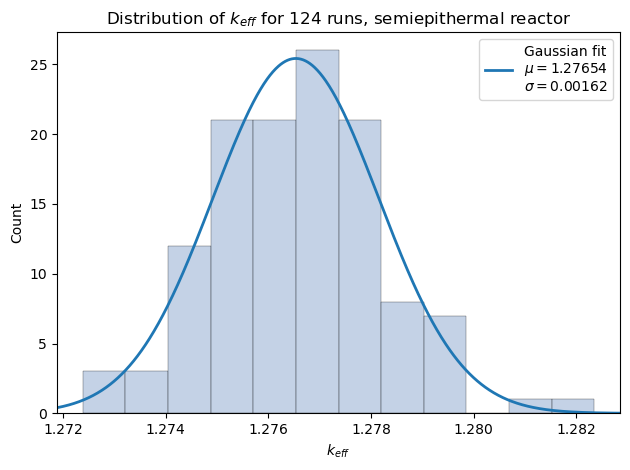

In [2]:
importlib.reload(plot_tools)
importlib.reload(model_tools)

# PLOT SETTINGS:
REACTOR_MODEL = model_tools.SEMIEPITHERMAL_REACTOR
USE_SAMPLED_DATA = True

SAMPLED_STRING = "SAMPLED" if USE_SAMPLED_DATA else "NOT_SAMPLED"

folder_name = f"plots-{REACTOR_MODEL}-{SAMPLED_STRING}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-{REACTOR_MODEL}-{SAMPLED_STRING}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filters
df = df[df["reactor_model"] == REACTOR_MODEL]
df = df[df["use_sampled_data"] == USE_SAMPLED_DATA]

if df.empty:
    raise Exception("No results found!")

df = data_tools.add_reactivity_to_df(df)

plt.figure()
fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for {len(df)} runs, {REACTOR_MODEL.lower()} reactor", x_label="$k_{eff}$", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-k_eff"))

# plt.figure()
# fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="rho-pcm", color="mediumseagreen",
#                                         fit_gaussian=True, decimals=0,
#                                         title=fr"Distribution of $\rho$ for {len(df)} runs", x_label=r"$\rho$ [pcm]", y_label="Count",
#                                         filename=get_filename("heatmap", "distribution-rho"))

In [3]:
importlib.reload(plot_tools)
importlib.reload(data_tools)
importlib.reload(model_tools)
import pickle

# Create a dataframe from the results
df = pd.DataFrame(results)

# TMC analysis
for REACTOR_MODEL in [model_tools.SEMIEPITHERMAL_REACTOR]:
    tmc_v1_res = data_tools.perform_TMC_v1(df, REACTOR_MODEL, print_output=True)

    # Save dict to pickle file
    with open(f"R15-tmc_v1_res-{REACTOR_MODEL}.pkl", "wb") as f:
        pickle.dump(tmc_v1_res, f)

    print("")


TMC analysis v1
SEMIEPITHERMAL
Sampling all MTs
Based on 124 runs
 -- k_eff --
k_eff: 		1.277
σ_obs: 		1.65e-03
σ_stat_mean: 	3.13e-04
σ_ND: 		1.62e-03
R_obs: 		129.3 pcm
R_stat_mean: 	24.5 pcm
R_ND: 		126.9 pcm
 -- ρ --
ρ: 		21666.4 pcm
ρ-std: 		99.4 pcm

